In [1]:
import numpy as np
from scipy import ndimage
from skimage import io
import matplotlib.pyplot as plt
from skimage.draw import line, ellipse


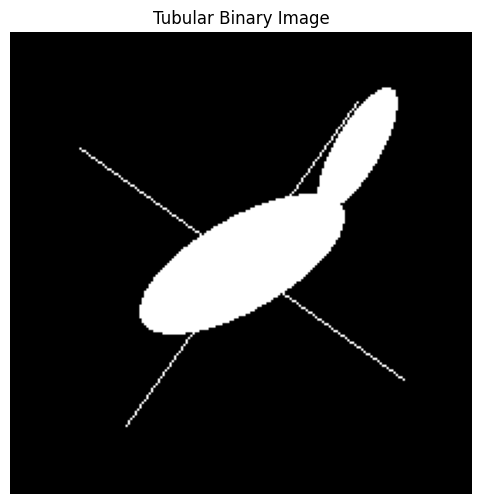

In [15]:
def generate_tubular_image(shape, structures):
    """
    Generate a binary image with tubular structures.
    
    Parameters:
    - shape: Tuple representing the shape of the image (height, width).
    - structures: List of dictionaries representing the tubular structures to draw.
                  Each dictionary should have a 'type' key with value 'line' or 'ellipse',
                  and corresponding parameters for the shape.
    
    Returns:
    - binary_image: Generated binary image with tubular structures.
    """
    binary_image = np.zeros(shape, dtype=np.uint8)
    
    for structure in structures:
        if structure['type'] == 'line':
            rr, cc = line(structure['start'][0], structure['start'][1], structure['end'][0], structure['end'][1])
            binary_image[rr, cc] = 1
        if structure['type'] == 'ellipse':
            rr, cc = ellipse(structure['center'][0], structure['center'][1], structure['r_radius'], structure['c_radius'], rotation=structure.get('rotation', 0))
            binary_image[rr, cc] = 1
    
    return binary_image

# Define the shape of the image
image_shape = (200, 200)

# Define the tubular structures to draw
tubular_structures = [
    {'type': 'line', 'start': (50, 30), 'end': (150, 170)},
    {'type': 'ellipse', 'center': (100, 100), 'r_radius': 20, 'c_radius': 50, 'rotation': np.deg2rad(30)},
    {'type': 'line', 'start': (30, 150), 'end': (170, 50)},
    {'type': 'ellipse', 'center': (50, 150), 'r_radius': 10, 'c_radius': 30, 'rotation': np.deg2rad(60)}
]

# Generate the binary image
binary_image = generate_tubular_image(image_shape, tubular_structures)
np.save('data/tubular_image.npy', binary_image)

# Visualize the binary image
plt.figure(figsize=(6, 6))
plt.imshow(binary_image, cmap='gray')
plt.title('Tubular Binary Image')
plt.axis('off')
plt.show()

In [17]:
# Pick which image to use
binary_image = np.load("data/circle.npy")

Compute the Hessian matrix

https://ieeexplore.ieee.org/abstract/document/9170749

In [57]:
# Apply a Gaussian filter to smooth the image slightly
smoothed_image = ndimage.gaussian_filter(binary_image.astype(float), sigma=1)

# Compute second-order derivatives
d2x = ndimage.gaussian_filter(smoothed_image, sigma=1, order=(2, 0))  # ∂²I/∂x²
d2y = ndimage.gaussian_filter(smoothed_image, sigma=1, order=(0, 2))  # ∂²I/∂y²
dxy = ndimage.gaussian_filter(smoothed_image, sigma=1, order=(1, 1))  # ∂²I/∂x∂y


Construct the Hessian Matrix for Each Pixel

In [19]:
# Loop through each pixel and construct the Hessian matrix
hessian_matrix = np.zeros((binary_image.shape[0], binary_image.shape[1], 2, 2))

hessian_matrix[:, :, 0, 0] = d2x  # ∂²I/∂x²
hessian_matrix[:, :, 1, 1] = d2y  # ∂²I/∂y²
hessian_matrix[:, :, 0, 1] = hessian_matrix[:, :, 1, 0] = dxy  # ∂²I/∂x∂y (off-diagonal)

Analyze the Hessian Matrix (Optional): If you want to identify ridge-like or tubular structures, you can compute the eigenvalues of the Hessian matrix. The eigenvalues indicate the local curvature around each point in the image. In particular, tubular structures often correspond to regions where one eigenvalue is significantly smaller than the other (indicating elongation).

In [20]:
from numpy import linalg as LA

# Compute the eigenvalues of the Hessian matrix for each pixel
eigenvalues = np.zeros((binary_image.shape[0], binary_image.shape[1], 2))
for i in range(binary_image.shape[0]):
    for j in range(binary_image.shape[1]):
        hessian = hessian_matrix[i, j]
        eigenvalues[i, j] = LA.eigvalsh(hessian)  # Compute eigenvalues

Visualize the Result: You can plot the eigenvalues or use them to enhance tubular structures by thresholding or other filtering techniques.

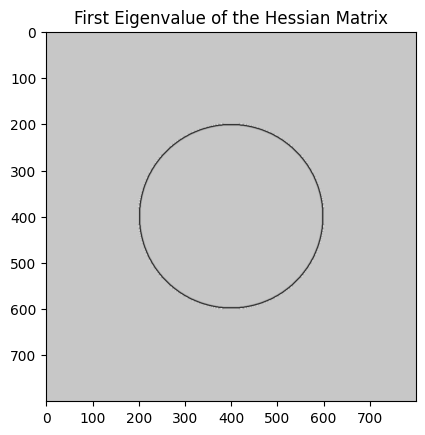

In [21]:
# Visualize one of the eigenvalues
plt.imshow(eigenvalues[:, :, 0], cmap='gray')
plt.title('First Eigenvalue of the Hessian Matrix')
plt.show()

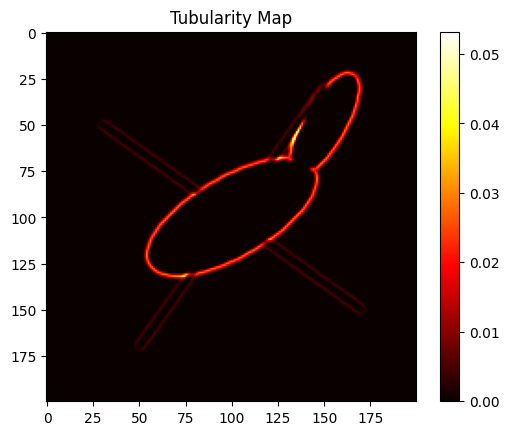

Mean Tubularity: 0.0004869268918470273
Standard Deviation: 0.0029836887005660153
Max Tubularity: 0.053203652220161816
Min Tubularity: 0.0


In [54]:
import numpy as np
from scipy import ndimage
from numpy import linalg as LA

def compute_hessian(image, sigma=1):
    """Compute the Hessian matrix for the image."""
    smoothed_image = ndimage.gaussian_filter(image.astype(float), sigma=sigma)

    d2x = ndimage.gaussian_filter(smoothed_image, sigma=sigma, order=(2, 0))  # ∂²I/∂x²
    d2y = ndimage.gaussian_filter(smoothed_image, sigma=sigma, order=(0, 2))  # ∂²I/∂y²
    dxy = ndimage.gaussian_filter(smoothed_image, sigma=sigma, order=(1, 1))  # ∂²I/∂x∂y

    return d2x, d2y, dxy

def compute_tubularity(d2x, d2y, dxy, alpha=0.5, beta=0.5):
    """Calculate the tubularity value for each pixel based on the Hessian eigenvalues."""
    rows, cols = d2x.shape
    tubularity_map = np.zeros((rows, cols))

    # Loop through each pixel to calculate the eigenvalues
    for i in range(rows):
        for j in range(cols):
            # Construct the Hessian matrix
            hessian = np.array([[d2x[i, j], dxy[i, j]], [dxy[i, j], d2y[i, j]]])

            # Compute eigenvalues
            eigenvalues = LA.eigvalsh(hessian)
            lambda1, lambda2 = np.sort(eigenvalues)  # Ensure lambda1 <= lambda2

            # Apply the tubularity measure (Frangi's formula or similar)
            if lambda2 < 0:  # Discard negative curvature regions
                tubularity_map[i, j] = 0
            else:
                tubularity_map[i, j] = np.exp(-lambda1**2 / (2 * alpha**2)) * (1 - np.exp(-lambda2**2 / (2 * beta**2)))

    return tubularity_map

# Example usage
from skimage import io, img_as_float
import matplotlib.pyplot as plt

# Load a binary tubular structure image
image = np.load("data/tubular_image.npy")
binary_image = image > 0.5  # Convert to binary if needed

# Compute the Hessian matrix
d2x, d2y, dxy = compute_hessian(binary_image, sigma=1)

# Compute the tubularity map
tubularity_map = compute_tubularity(d2x, d2y, dxy)

# Visualize the tubularity map
plt.imshow(tubularity_map, cmap='hot')
plt.title('Tubularity Map')
plt.colorbar()
plt.show()

mean_tubularity = np.mean(tubularity_map)
std_tubularity = np.std(tubularity_map)
max_tubularity = np.max(tubularity_map)
min_tubularity = np.min(tubularity_map)

print(f"Mean Tubularity: {mean_tubularity}")
print(f"Standard Deviation: {std_tubularity}")
print(f"Max Tubularity: {max_tubularity}")
print(f"Min Tubularity: {min_tubularity}")



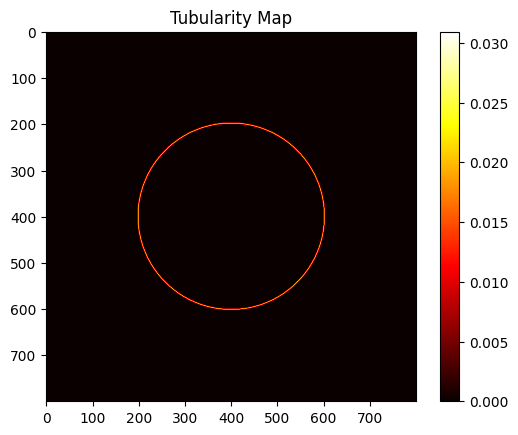

Mean Tubularity: 9.988192961507586e-05
Standard Deviation: 0.0014499457004317042
Max Tubularity: 0.030928674691123377
Min Tubularity: 0.0


In [56]:
# Load a binary tubular structure image
image = np.load("data/circle.npy")
binary_image = image > 0.5  # Convert to binary if needed

# Compute the Hessian matrix
d2x, d2y, dxy = compute_hessian(binary_image, sigma=1)

# Compute the tubularity map
tubularity_map = compute_tubularity(d2x, d2y, dxy)

# Visualize the tubularity map
plt.imshow(tubularity_map, cmap='hot')
plt.title('Tubularity Map')
plt.colorbar()
plt.show()

mean_tubularity = np.mean(tubularity_map)
std_tubularity = np.std(tubularity_map)
max_tubularity = np.max(tubularity_map)
min_tubularity = np.min(tubularity_map)

print(f"Mean Tubularity: {mean_tubularity}")
print(f"Standard Deviation: {std_tubularity}")
print(f"Max Tubularity: {max_tubularity}")
print(f"Min Tubularity: {min_tubularity}")



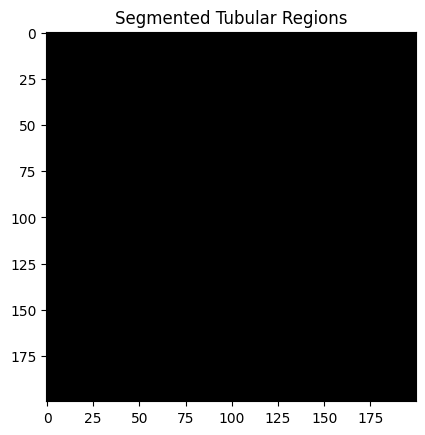

In [55]:
threshold = 1e-1  # Adjust this value depending on your data
tubular_regions = tubularity_map > threshold

plt.imshow(tubular_regions, cmap='gray')
plt.title('Segmented Tubular Regions')
plt.show()


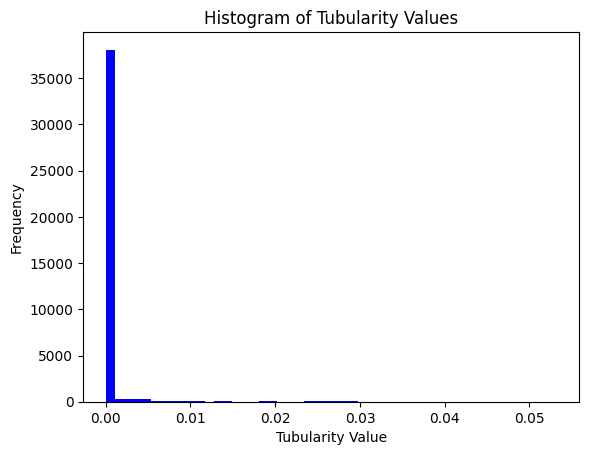

In [28]:
plt.hist(tubularity_map.ravel(), bins=50, color='blue')
plt.title('Histogram of Tubularity Values')
plt.xlabel('Tubularity Value')
plt.ylabel('Frequency')
plt.show()


Number of Tubular Structures: 3


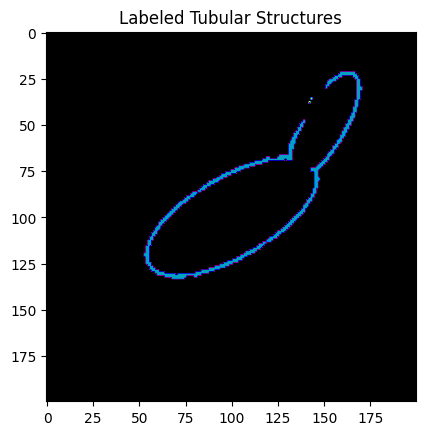

In [29]:
from skimage import measure

labels = measure.label(tubular_regions, connectivity=2)
num_labels = np.max(labels)

print(f"Number of Tubular Structures: {num_labels}")

plt.imshow(labels, cmap='nipy_spectral')
plt.title('Labeled Tubular Structures')
plt.show()


In [30]:
from skimage.measure import regionprops

regions = regionprops(labels)
for i, region in enumerate(regions):
    print(f"Region {i+1}:")
    print(f" - Area: {region.area}")
    print(f" - Bounding Box: {region.bbox}")
    print(f" - Eccentricity: {region.eccentricity}")
    print(f" - Major Axis Length: {region.major_axis_length}")
    print(f" - Minor Axis Length: {region.minor_axis_length}")


Region 1:
 - Area: 661
 - Bounding Box: (22, 53, 134, 171)
 - Eccentricity: 0.9370646270818295
 - Major Axis Length: 183.10888052241464
 - Minor Axis Length: 63.93355703372632
Region 2:
 - Area: 1
 - Bounding Box: (36, 143, 37, 144)
 - Eccentricity: 0
 - Major Axis Length: 0.0
 - Minor Axis Length: 0.0
Region 3:
 - Area: 1
 - Bounding Box: (38, 142, 39, 143)
 - Eccentricity: 0
 - Major Axis Length: 0.0
 - Minor Axis Length: 0.0


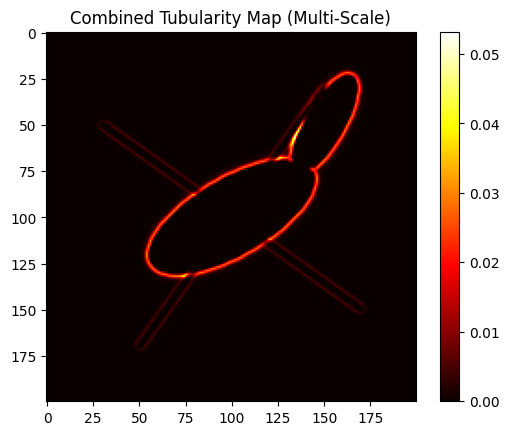

In [31]:
scales = [1, 2, 3]
tubularity_maps = [compute_tubularity(*compute_hessian(binary_image, sigma=s)) for s in scales]

# Combine the maps (e.g., by taking the maximum tubularity across scales)
combined_tubularity = np.maximum.reduce(tubularity_maps)

plt.imshow(combined_tubularity, cmap='hot')
plt.colorbar()
plt.title('Combined Tubularity Map (Multi-Scale)')
plt.show()
